In [102]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import requests
import json
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
load_dotenv()

# Acessa a variável de ambiente
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
symbol = 'AAPL'  # Use o símbolo da ação que você quer monitorar

In [9]:
# URL para obter dados diários de uma ação
url_stock = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}"

# Requisição HTTP
response_stock = requests.get(url_stock)
data_stock = response_stock.json()

url_opt = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={symbol}&apikey={api_key}"
&apikey={api_key}'
response_opt = requests.get(url_opt)
data_opt = response_opt.json()

In [ ]:
df_stock = pd.DataFrame.from_dict(data_stock['data'])
df_opt = pd.DataFrame.from_dict(data_opt['data'])

In [171]:
with open('./stock_data.json', 'r') as file:
    data_stock = json.load(file)

with open('./options_data.json', 'r') as file:
    data_opt = json.load(file)

df_stock = pd.DataFrame.from_dict(data_stock['Time Series (Daily)'], orient='index')
df_opt = pd.DataFrame.from_dict(data_opt['data'])

In [172]:
df_stock.reset_index(inplace=True)
df_stock.columns = ['Date','Open','High','Low','Close','Volume_stock']

In [173]:
df_opt.columns = df_opt.columns.map(lambda x: x.capitalize())
df_opt.rename(columns={'Volume':'Volume_option'}, inplace = True)
# df_opt.Volume_option = df_opt.Volume_option.astype(float)
# df_opt = df_opt[df_opt.Volume_option > 0]

df_aapl = df_stock.merge(df_opt, on='Date', how='inner')

In [174]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume_stock',
              'Strike', 'Last', 'Mark', 'Bid',
              'Bid_size', 'Ask', 'Ask_size', 'Volume_option', 'Open_interest',
              'Implied_volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
df_aapl[numeric_cols] = df_aapl[numeric_cols].astype(float)

In [175]:
def generate_stats(df, col):
    # Realizar o teste de Shapiro-Wilk
    stat, p_value = stats.shapiro(df[col])

    print(f'Estatística: {stat}, p-value: {p_value}')

    if p_value < 0.05:
        print("Os dados não seguem uma distribuição normal (p < 0.05).")
    else:
        print("Os dados seguem uma distribuição normal (p >= 0.05).")

    # Plotar o Q-Q plot para verificar normalidade
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title('Q-Q Plot do Volume de Opções')
    plt.show()    

    skewness = stats.skew(df[col])
    kurt = stats.kurtosis(df[col])

    print(f'Skewness: {skewness}')
    print(f'Kurtosis: {kurt}')

def histplot(df, col):
    # Visualizar a nova distribuição
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title('Distribuition')
    plt.xlabel('Volume')
    plt.ylabel('Fréquence')
    plt.show()

In [176]:
# Aplicar transformação Box-Cox
df_aapl['boxcox_Implied_vol'], _ = stats.boxcox(df_aapl['Implied_volatility'] + 1)  # Adicionar 1 para evitar zero


Estatística: 0.956585590517936, p-value: 6.962354367959767e-26
Os dados não seguem uma distribuição normal (p < 0.05).


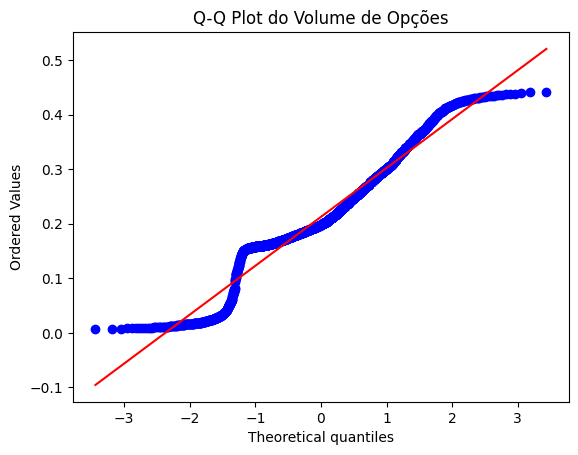

Skewness: 0.04753855161067056
Kurtosis: 0.32183818226232397


In [177]:
generate_stats(df_aapl, 'boxcox_Implied_vol')

In [178]:
# Calcular o IQR (Intervalo Interquartil)
Q1 = df_aapl['boxcox_Implied_vol'].quantile(0.25)
Q3 = df_aapl['boxcox_Implied_vol'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
outliers_iqr = df_aapl[(df_aapl['boxcox_Implied_vol'] < (Q1 - 1.5 * IQR)) | 
                                 (df_aapl['boxcox_Implied_vol'] > (Q3 + 1.5 * IQR))]

# Exibir os outliers identificados
outliers_iqr[['Expiration', 'Strike', 'Type', 'Last', 'Mark', 'Bid',
       'Bid_size', 'Ask', 'Ask_size', 'Volume_option', 'Open_interest',
       'Implied_volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho',
       'boxcox_Implied_vol']]

,Expiration,Strike,Type,Last,Mark,Bid,Bid_size,Ask,Ask_size,Volume_option,Open_interest,Implied_volatility,Delta,Gamma,Theta,Vega,Rho,boxcox_Implied_vol
0,2024-10-11,100.0,call,124.05,129.70,129.20,72.0,130.20,60.0,0.0,1.0,4.64792,0.99517,0.00018,-1.05789,0.00238,0.00541,0.435377
1,2024-10-11,100.0,put,0.00,0.01,0.00,0.0,0.01,2019.0,0.0,9.0,3.60023,-0.00057,0.00003,-0.11243,0.00034,-0.00001,0.430076
2,2024-10-11,105.0,call,0.00,124.70,124.15,67.0,125.25,71.0,0.0,0.0,4.38817,0.99493,0.00020,-1.04611,0.00249,0.00568,0.434367
3,2024-10-11,105.0,put,0.00,0.01,0.00,0.0,0.08,218.0,0.0,1.0,3.39871,-0.00061,0.00004,-0.11196,0.00036,-0.00001,0.428555
4,2024-10-11,110.0,call,0.00,119.70,119.20,76.0,120.20,66.0,0.0,0.0,4.14077,0.99468,0.00022,-1.03424,0.00260,0.00595,0.433247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2027-01-15,120.0,call,114.00,120.58,118.65,82.0,122.50,82.0,0.0,8.0,0.00924,1.00000,0.00000,-0.05194,0.00000,2.43969,0.009103
2264,2027-01-15,125.0,call,111.95,116.47,114.85,52.0,118.10,30.0,0.0,35.0,0.00882,1.00000,0.00000,-0.05411,0.00000,2.54134,0.008695
2266,2027-01-15,130.0,call,109.70,112.12,110.50,52.0,113.75,30.0,0.0,1.0,0.00840,1.00000,0.00000,-0.05627,0.00000,2.64299,0.008287
2268,2027-01-15,135.0,call,103.40,108.10,106.75,52.0,109.45,22.0,0.0,2.0,0.00797,1.00000,0.00000,-0.05844,0.00000,2.74465,0.007868
